# Location regression with only smooth terms

In [22]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

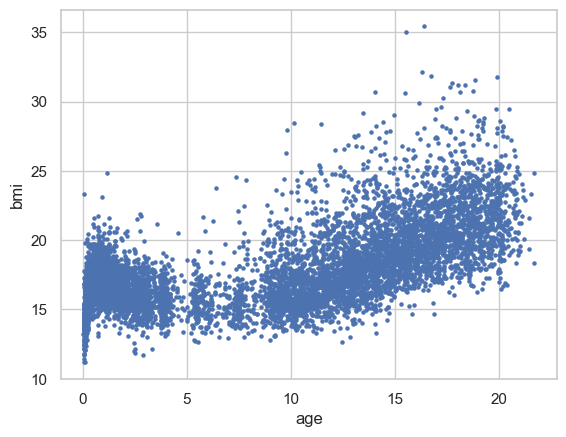

In [23]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [24]:
# Standardize response 
# Could be an idea to standardize the response for numerical stability 
y_test = (df["bmi"].to_numpy() - df["bmi"].to_numpy().mean())/df["bmi"].to_numpy().std()

In [25]:
# Set up design matrix 
X = tiger.Obs(name="X_loc", intercept=False)
X.smooth(data=df["age"].to_numpy(), n_knots=20)

# Set up hyperparameters for the beta_scale  
tau_a = tiger.Hyper(1.0, name="tau_a")
tau_b = tiger.Hyper(0.00005, name="tau_b")
tau_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=1.0, distribution=tau_dist, param_space="positive", name="tau")

# Set up hyperparameters
beta_smooth_loc = tiger.Hyper(jnp.zeros(X.smooth_dim[0]), name="beta_smooth_loc")

# Define the penaly matrix from class Obs
pen = X.smooth_pen_mat[0]

# Set up parameters 
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=pen)
beta_smooth = tiger.Param(value=jnp.repeat(df["bmi"].to_numpy().mean(), X.smooth_dim[0]), distribution=beta_smooth_dist, name="beta_smooth")

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up the linear predictor 
lpred = tiger.Lpred(obs=X, beta_smooth=beta_smooth)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

In [26]:
m.log_prob

Array(-23834.705, dtype=float32)

In [27]:
m.log_prior 

Array(-28.668533, dtype=float32)

In [28]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [29]:
graph.logprob()

Array(-23834.705, dtype=float32)

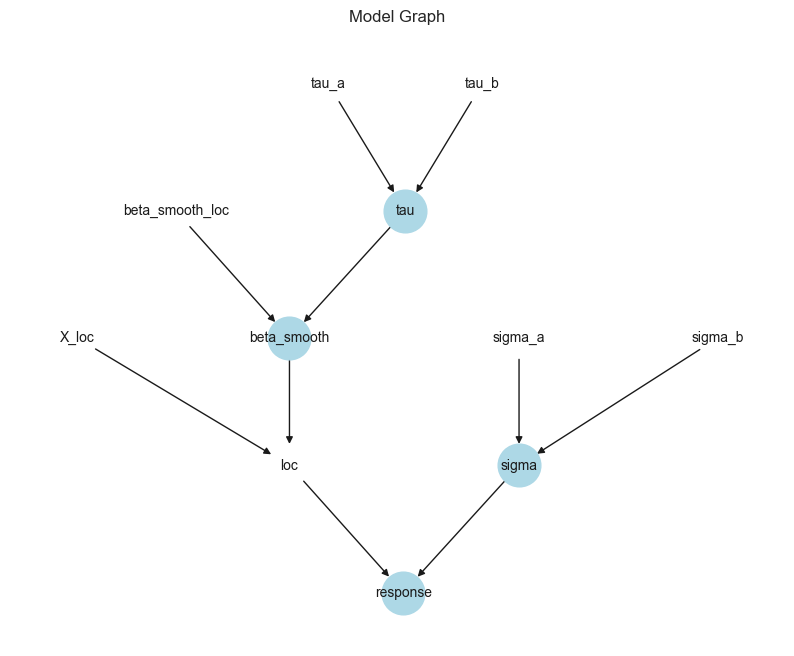

In [30]:
graph.visualize_graph()

## Test functions of Bbvi

In [31]:
import tigerpy.distributions.mvn as mvn
q = bbvi.Bbvi(graph=graph)
key = jax.random.PRNGKey(27)
key, *subkeys = jax.random.split(key, len(q.init_variational_params)+1)

AttributeError: 'Bbvi' object has no attribute 'init_variational_params'

In [18]:
loc_beta_smooth, lower_tri_beta_smooth = q.init_variational_params["beta_smooth"]["loc"], q.init_variational_params["beta_smooth"]["lower_tri"]
loc_sigma, lower_tri_sigma = q.init_variational_params["sigma"]["loc"], q.init_variational_params["sigma"]["lower_tri"]
loc_tau, lower_tri_tau= q.init_variational_params["tau"]["loc"], q.init_variational_params["tau"]["lower_tri"]

In [19]:
samples_beta_smooth = mvn.mvn_precision_chol_sample(loc=loc_beta_smooth, precision_matrix_chol=lower_tri_beta_smooth, key=subkeys[0], S=64)
samples_sigma = mvn.mvn_precision_chol_sample(loc=loc_sigma, precision_matrix_chol=lower_tri_sigma, key=subkeys[1], S=64)
samples_tau = mvn.mvn_precision_chol_sample(loc=loc_tau, precision_matrix_chol=lower_tri_tau, key=subkeys[2], S=64)

In [20]:
test_samples = {"beta_smooth": samples_beta_smooth,
                "sigma": jnp.exp(samples_sigma),
                "tau": jnp.exp(samples_tau)}

In [21]:
batch_idx = jax.random.choice(key, q.num_obs, (32,), replace=False)

In [22]:
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [23]:
q.mc_logprob(data_new,  test_samples, q.num_obs)

Array(-37564.883, dtype=float32)

In [24]:
q.lower_bound(q.init_variational_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

Array(29724.887, dtype=float32)

## Inference with Bbvi

In [60]:
q = bbvi.Bbvi(graph=graph)

In [61]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=1,
           batch_size=2048,
           num_var_samples=64,
           chunk_size=50,
           epochs=1000)

(Array(-15744.932, dtype=float32, weak_type=True),
 {'loc': Array([17.282473, 16.543776, 15.995032, 16.530182, 15.754171, 15.556147,
         15.881786, 16.30641 , 16.600935, 16.857023, 17.380177, 17.886305,
         18.450697, 19.128626, 19.577135, 20.146315, 20.82785 , 21.357157,
         21.719671, 21.951305], dtype=float32)})

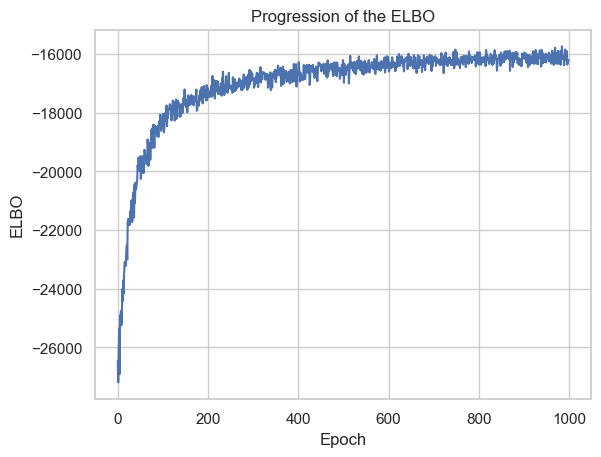

In [62]:
q.plot_elbo()

## Visualize the regression line 

In [63]:
b = q.trans_var_params["beta_smooth"]["loc"]
b

Array([17.282473, 16.543776, 15.995032, 16.530182, 15.754171, 15.556147,
       15.881786, 16.30641 , 16.600935, 16.857023, 17.380177, 17.886305,
       18.450697, 19.128626, 19.577135, 20.146315, 20.82785 , 21.357157,
       21.719671, 21.951305], dtype=float32)

In [64]:
# plot the regression line 
b = q.trans_var_params["beta_smooth"]["loc"]
x_new = jnp.linspace(df["age"].to_numpy().min(), df["age"].to_numpy().max(), num=100)
X_new = tiger.Obs(name="X_pred", intercept=False)
X_new.smooth(data = x_new, n_knots=20)
y = X_new.design_matrix @ b
#y = (X_new.design_matrix @ b)*df["bmi"].to_numpy().std() + df["bmi"].to_numpy().mean()

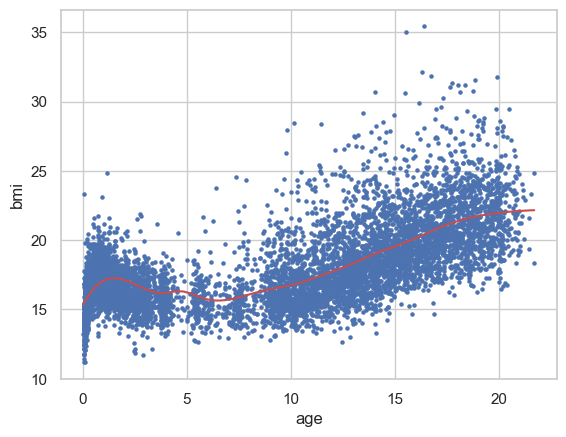

In [65]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(x_new, y, color = "r")
#ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [55]:
tau = q.trans_var_params["tau"]["loc"]
s = q.trans_var_params["tau"]["cov"]

In [56]:
tau, s

(Array([-0.5146284], dtype=float32, weak_type=True),
 Array([[0.02646678]], dtype=float32))

In [57]:
mean = jnp.exp(tau + s/2)
mean

Array([[0.6056851]], dtype=float32)

In [58]:
1 / (mean ** 2)

Array([[2.7258766]], dtype=float32)

In [59]:
1 / (0.54 ** 2)

3.429355281207133